## Temporary free-lick task analysis

### Initial setup

In [19]:
# Global imports
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Math packages
import math
from scipy.optimize import broyden1
import scipy.signal as signal
from scipy.signal import spectrogram

# Data file processing
import os
import re
import h5py # if using -v7.3 mat data
#import scipy.io as sio # if using -v7 mat data
from scipy.stats import norm # for z-score calculation

In [2]:
# Recursive algorithm for finding files
def find_files(path, files):
    # If path is file, then append to list
    if os.path.isfile(path):
        files.append(path)
        return
    
    # Otherwise, iterate through all children (files/subdirectories)
    for f in os.listdir(path):
        _ = find_files(os.path.join(path, f), files)    
        
    return files

In [3]:
def flatten_list(a):
    """Converts list of arrays into single 1D array"""
    # Determine total number of elements in list
    n = 0
    for a_i in a:
        n += a_i.size
        
    # Build flattened array
    a_flat = np.zeros(n)
    j = 0
    for i, a_i in enumerate(a):
        a_flat[j:j+a_i.size] = a_i.flatten()
        j += a_i.size
    
    return a_flat

In [4]:
def remove_outliers(a, thresh=2.0):
    mean = np.mean(a)
    std = np.std(a)
    return a[np.logical_and(a > mean-thresh*std, a < mean+thresh*std)]

In [5]:
cmap = plt.get_cmap('Greys')

### Create filelist

In [9]:
# Experiment parameters
mouse_id = 'j6z5'
exp_name = 'free_lick\\%s' % mouse_id
exp_desc = 'data shape = [session, reward_thresh, num_sims]\n' \
           + 'included only first few sessions for old walk-bout data'
results_dir = 'G:\\My Drive\\Projects\\foraging\\data\\simulation_data\\%s\\' % exp_name
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

In [10]:
# Settings
root = 'Y:\\James\\data\\' # root directory of all data files
exclude_str = 'Sound'

# Filter files by matlab extension, mouse ID
files = find_files(root, [])
filelist = []
ext = '.mat'
for file in files:
    if (file.endswith(ext)
        and mouse_id in file
        and exclude_str not in file):
        filelist.append(file)

# Find training days of all files
training_days = np.zeros(len(filelist), dtype=np.int16)
for i, f in enumerate(filelist):
    match = re.search('_d[0-9]+_', f)
    if match is not None:
        training_days[i] = int(match.group()[2:-1])
    else:
        training_days[i] = -1

# Sort filenames and save associated training days
keep_idx = (training_days >= 0)
training_days = training_days[keep_idx]
filelist = [f for i, f in enumerate(filelist) if keep_idx[i]]
sort_idx = np.argsort(training_days)
filelist = [filelist[i] for i in sort_idx]
training_days = np.sort(training_days)

# Check filelist
print('Files to analyze:')
print('Day  Filename')
for day, f in zip(training_days, filelist):
    print('%2d: ' % day, f)

Files to analyze:
Day  Filename
 2:  Y:\James\data\ChamberB\12-21-18\j6z5_d02_2018_12_21_11_42_36.mat
 3:  Y:\James\data\ChamberB\12-27-18\j6z5_d03_2018_12_27_14_55_25.mat
 4:  Y:\James\data\ChamberA\12-28-18\j6z5_d04_2018_12_28_15_01_30.mat
 5:  Y:\James\data\ChamberB\12-31-18\j6z5_d05_2018_12_31_14_32_59.mat
 6:  Y:\James\data\ChamberB\01-02-19\j6z5_d06_2019_01_02_14_56_10.mat
 9:  Y:\James\data\ChamberA\01-07-19\j6z5_d09_2019_01_07_09_41_51.mat
10:  Y:\James\data\ChamberA\01-08-19\j6z5_d10_2019_01_08_14_54_05.mat
12:  Y:\James\data\ChamberA\01-10-19\j6z5_d12_2019_01_10_16_05_41.mat
13:  Y:\James\data\ChamberB\01-11-19\j6z5_d13_2019_01_11_12_36_54.mat
14:  Y:\James\data\ChamberA\01-14-19\j6z5_d14_2019_01_14_11_33_17.mat
15:  Y:\James\data\ChamberA\01-15-19\j6z5_d15_2019_01_15_10_49_29.mat
16:  Y:\James\data\ChamberB\01-16-19\j6z5_d16_2019_01_16_11_13_15.mat
17:  Y:\James\data\ChamberA\01-17-19\j6z5_d17_2019_01_17_12_35_28.mat
21:  Y:\James\data\ChamberB\01-29-19\j6z5_d21_2019_01_29_1

### Harvest rate

In [11]:
hr = np.zeros(len(filelist))
for i, filename in enumerate(filelist):
    with h5py.File(filename) as f:
        print('Processing session %d of %d...' % (training_days[i], training_days[-1]))
        
        t_total = (f['UntitledWheelTime']['Data'][0, -1])
        r_total = np.sum(f['UntitledRewarduL']['Data'])
        hr[i] = r_total / t_total

Processing session 2 of 25...
Processing session 3 of 25...
Processing session 4 of 25...
Processing session 5 of 25...
Processing session 6 of 25...
Processing session 9 of 25...
Processing session 10 of 25...
Processing session 12 of 25...
Processing session 13 of 25...
Processing session 14 of 25...
Processing session 15 of 25...
Processing session 16 of 25...
Processing session 17 of 25...
Processing session 21 of 25...
Processing session 22 of 25...
Processing session 24 of 25...
Processing session 25 of 25...


### Patch residence time and travel time

In [12]:
dt_patch = []
dt_interpatch = []
for i, filename in enumerate(filelist):
    with h5py.File(filename) as f:
        print('Processing session %d of %d...' % (training_days[i], training_days[-1]))
        
        dt_patch_ = f['UntitledPatchTime']['Data'][0, :]
        dt_patch.append(dt_patch_)
        
        t_patch_start = (f['UntitledPatchStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
        if len(dt_patch_) > 1:
            t_patch_end = (f['UntitledPatchEndms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
        else:
            t_patch_end = [None]
        # If end in patch, count all interpatches
        if len(t_patch_start) == (len(t_patch_end) + 1):
            dt_interpatch.append(t_patch_start[1:] - t_patch_end)

        # If end in interpatch, drop last interpatch
        elif len(t_patch_start) == len(t_patch_end):
            dt_interpatch.append(t_patch_start[1:] - t_patch_end[:-1])

        else:
            raise ValueError('Patch/interpatch timestamps not understood: '
                             + '# patch starts = %d, # patch ends = %d' % (len(t_patch_start), len(t_patch_end)))

Processing session 2 of 25...
Processing session 3 of 25...
Processing session 4 of 25...
Processing session 5 of 25...
Processing session 6 of 25...
Processing session 9 of 25...
Processing session 10 of 25...
Processing session 12 of 25...
Processing session 13 of 25...
Processing session 14 of 25...
Processing session 15 of 25...
Processing session 16 of 25...
Processing session 17 of 25...
Processing session 21 of 25...
Processing session 22 of 25...
Processing session 24 of 25...
Processing session 25 of 25...


### Find optimal values

In [13]:
def cumulative_reward(t_p, R_0, r_0, tau):
    return r_0 * tau * (1.0 - np.exp(-t_p / tau)) + R_0
    
def get_optimal_values(t_t, R_0, r_0, tau):
    # Minimum travel time: R_0 / r_0
    if t_t < (R_0 / r_0):
        print('Travel time is less than minimum. Ignoring R_0.')
        R_0 = 0.0
    
    # Solve non-linear equation for residence time
    F = lambda x: (r_0 * np.exp(-x/tau) * (t_t + x + tau)) - (r_0 * tau) - R_0
    #t_p = scipy.optimize.broyden1(F, -100) # negative solution
    t_p_opt = broyden1(F, 10*tau) # positive solution
    
    # Calculate total harvested reward for optimal residence time
    r_opt = cumulative_reward(t_p_opt, R_0, r_0, tau)
    
    return t_p_opt, r_opt

In [14]:
dt_patch_opt = np.zeros(len(filelist))
hr_opt = np.zeros(len(filelist))
r_diff = []
for i, filename in enumerate(filelist):
    with h5py.File(filename) as f:
        print('Processing session %d of %d...' % (training_days[i], training_days[-1]))
        
        velocity = 3.0 # cm/s
        
        # Environment parameters
        struct = f['Settings']['Property'] # matlab data structure
        d_interpatch = struct['SoundConfigurationRunConfigInterPatchDistcm'] # char array
        d_interpatch = float([u''.join(chr(c) for c in d_interpatch)][0]) # float
        R_0 = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigIniVoluL'])][0])
        r_0 = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigIniRateuLsec'])][0])
        tau = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTCsec'])][0])
        
        # Optimal behavior
        t_t = d_interpatch / velocity
        t_p_opt, r_opt = get_optimal_values(t_t, R_0, r_0, tau)
        dt_patch_opt[i] = t_p_opt
        hr_opt[i] = r_opt / (t_p_opt + t_t)        

Processing session 2 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 3 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 4 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 5 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 6 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 9 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 10 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 12 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 13 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 14 of 25...
Travel time is less than minimum. Ignoring R_0.


C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\scipy\optimize\nonlin.py:1000: RuntimeWarning: invalid value encountered in true_divide
  d = v / vdot(df, v)


Processing session 15 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 16 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 17 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 21 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 22 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 24 of 25...
Travel time is less than minimum. Ignoring R_0.
Processing session 25 of 25...
Travel time is less than minimum. Ignoring R_0.


### Lick and motor analysis

In [15]:
def med_filt(x, n=3):
    X = np.zeros([n, len(x)])
    for i in range(n):
        X[i] = np.roll(x, -n//2 + i)
    
    x_filt = np.median(X, axis=0)
    for i in range(n//2):
        x_filt[i] = np.median(X[(n//2 - i):, i])
        x_filt[-(i+1)] = np.median(X[:(n//2 + i), -(i+1)])
   
    return x_filt

def lowpass_butter_filter(s, fs, fc, order=5):
    """Apply low-pass butter filter to signal."""
    nyq = 0.5 * fs
    fc = fc / nyq
    b, a = signal.butter(order, fc, btype='low')
    y = signal.lfilter(b, a, s)
    
    return y

def preprocess_sound(wf, fs, med_filter_size=30, butter_filter_fc=10):
    f_s, t_s, s = spectrogram(wf, fs=fs)
    #s_var = np.sum((s - np.mean(s, axis=0, keepdims=True))**2, axis=0)
    s_var = np.median(np.abs(np.diff(s, axis=0)), axis=0)
    fs_s = fs * (len(s_var)/len(wf))
    s_var_smooth = med_filt(s_var, n=med_filter_size)
    s_var_smooth = lowpass_butter_filter(s_var_smooth, fs_s, butter_filter_fc)
    
    return fs_s, t_s, s_var_smooth

def in_interval(t, t1, t2):
    gt_t1 = (t[np.newaxis, :] > t1[:, np.newaxis])
    lt_t2 = (t[np.newaxis, :] < t2[:, np.newaxis])
    
    return np.sum(np.logical_and(gt_t1, lt_t2).astype(np.int32), axis=0)

def _get_patches_from_sound(s, fs, thresh):
    # Determine data points in patch based on sound variance
    in_patch = (s < thresh).astype(np.int32)
    
    # Find patch start points
    t_patch_start = np.argwhere((in_patch - np.roll(in_patch, -1)) == -1).flatten()
    if (in_patch[-1] == 0) and (in_patch[0] == 1):
        # Correct wrap-around error
        t_patch_start = t_patch_start[:-1]
    if (np.sum(in_patch[:2]) == 2):
        # Correct first data point
        t_patch_start = np.insert(t_patch_start, 0, 0.0)
    
    # Find patch end points
    t_patch_end = np.argwhere((in_patch - np.roll(in_patch, -1)) == 1).flatten()
    if (in_patch[-1] == 1) and (in_patch[0] == 0):
        # Correct wrap-around error
        t_patch_end = t_patch_end[:-1]
    if t_patch_end[0] < t_patch_start[0]:
        # Correct initial error
        t_patch_end = t_patch_end[1:]
    
    # Drop last patch-interpatch sequence
    if len(t_patch_start) > len(t_patch_end):
        # End in patch: drop last patch
        t_stop = t_patch_start[-1]
        t_patch_start = t_patch_start[:-1]
    elif len(t_patch_start) == len(t_patch_end):
        # End in interpatch: drop last patch and interpatch
        t_stop = t_patch_start[-1]
        t_patch_start = t_patch_start[:-1]
        t_patch_end = t_patch_end[:-1]
    else:
        raise ValueError('Timestamps not understood: %d patch starts, %d patch stops'
                         % (len(t_patch_start), len(t_patch_end)))
        
    t_patch_start = t_patch_start.astype(np.float64) / fs
    t_patch_end = t_patch_end.astype(np.float64) / fs
    t_stop = t_stop.astype(np.float64) / fs
    
    return t_patch_start, t_patch_end, in_patch, t_stop

def get_patches_from_sound(s, 
                           dt_patch=None, 
                           auto_thresh=True, 
                           init_thresh=5.0e-9):
    # Get initial threshold
    if auto_thresh:
        thresh = find_threshold(s)
    else:
        thresh = init_thresh
    print('Variance threshold: %.2e' % thresh)
    
    # Attempt to extract patches with initial threshold
    t_patch_start, t_patch_end, in_patch, t_stop = \
        _get_patches_from_sound(s=s, 
                                fs=(len(s)/len(wf))*fs, 
                                thresh=thresh)
    
    if dt_patch is not None:
        # Check for agreement if patch durations provided
        if not compare_patch_times(t_patch_end - t_patch_start, dt_patch):
            print('Initial threshold failed. Trying range of values...')
            
            # Try range of values for threshold until agreement reached
            thresh_range = np.linspace(0.2*thresh, 5*thresh, 50)
            for thresh in thresh_range:
                try:
                    t_patch_start, t_patch_end, in_patch, t_stop = \
                        _get_patches_from_sound(s=s, 
                                                fs=(len(s)/len(wf))*fs, 
                                                thresh=thresh)
                except IndexError: # empty array handling
                    pass
                if compare_patch_times(t_patch_end - t_patch_start, dt_patch):
                    print('Successful threshold found: %.2e' % thresh)
                    break

    return t_patch_start, t_patch_end, in_patch, t_stop

def compare_patch_times(dt_patch_1, dt_patch_2, tol=1.0):
    """
    Compare patch durations from two sources 
    (e.g. sound waveform analysis vs. logged data)
    
    Note: When comparing to logged data, the number of patches alone
    is not sufficient to check for the correct handling of the sound 
    waveform. Comparing times directly is not only more robust, but 
    if the session ended in a patch, it is not clear when that patch
    duration is logged, meaning the number of patches can differ by 
    one even with correct waveform analysis.
    """
    idx_last = min(len(dt_patch_1), len(dt_patch_2))
    return np.isclose(dt_patch_1[:idx_last], 
                      dt_patch_2[:idx_last],
                      atol=tol).all()

def find_threshold(s, n_bins=25):
    """
    Finds threshold between two values for noisy binary function.
    Note: Fitting to two Gaussians often ignored the pink noise peak
    since it was proportionally much smaller.
    """
    # Create histogram of values
    hist, bin_edges = np.histogram(s, bins=n_bins)
    
    # Find local peaks
    peaks = []
    idx_peaks = []
    if hist[0] > hist[1]:
        peaks.append(hist[0])
        idx_peaks.append(0)
    for j in range(1, len(hist)-1):
        if hist[j] > hist[j-1] and hist[j] > hist[j+1]:
            peaks.append(hist[j])
            idx_peaks.append(j)
    if hist[-1] > hist[-2]:
        peaks.append(hist[-1])
        idx_peaks.append(-1)

    # Find values associated with greatest two local peaks
    idx_sort = np.argsort(np.asarray(peaks))
    idx_peaks = np.asarray(idx_peaks)[idx_sort[-2:]]
    bin_width = bin_edges[1] - bin_edges[0]
    x = bin_edges + 0.5*bin_width
    x_peaks = x[idx_peaks]

    # Return threshold halfway between two peaks
    return np.mean(x_peaks)

In [20]:
auto_thresh = True
init_thresh = 1e-12
fc = 10.0 # critical freq in Hz


dt_lick = []
n_lick_patch = []
n_lick_total =  []
r_patch_max = []
r_patch_obs = []
keep_idx = np.ones(len(filelist), dtype=np.bool)
for i, filename in enumerate(filelist):
    with h5py.File(filename) as f:
        print('Processing session %d of %d...' % (training_days[i], training_days[-1]))
        
        ### Session settings ###
        struct = f['Settings']['Property'] # matlab data structure
        chamber_id = str([u''.join(chr(c) for c in struct['ChamberID'])][0])[-2:]
        d_interpatch = struct['SoundConfigurationRunConfigInterPatchDistcm'] # char array
        d_interpatch = float([u''.join(chr(c) for c in d_interpatch)][0]) # float
        R_0 = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigIniVoluL'])][0])
        r_0 = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigIniRateuLsec'])][0])
        tau = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTCsec'])][0])
        flow_rate = float([u''.join(chr(c) for c in struct['DAQConfigurationPumpFlowRatemLmin'])][0])
        flow_rate = flow_rate * 1000 / 60 # uL/s
        
        ### Process sound waveform ###
        # Grab and preprocess sound waveform
        wf = f['UntitledSound' + chamber_id[-1]]['Data'][0, :]
        dt_wf = f['UntitledSound' + chamber_id[-1]]['Property']['wf_increment'][0, 0]
        fs = 1.0 / dt_wf
        fs_s, t_s, s_var_smooth = preprocess_sound(wf, fs, butter_filter_fc=fc)
        
        # Calculate patch start and end points from smoothed spectrogram variance
        # Note: We will always drop the last patch-interpatch sequence
        t_patch_start, t_patch_end, in_patch, t_stop = \
            get_patches_from_sound(s_var_smooth, dt_patch=dt_patch[i])
        if not compare_patch_times(t_patch_end - t_patch_start, dt_patch[i]):
            #raise ValueError('Number of patches from sound and log file do not match (%d vs. %d)'
            #                 % (len(t_patch_start), num_patches))
            print('No threshold found. Skipping file.')
            keep_idx[i] = False
            continue
        idx_stop = int(t_stop * fs) # idx of end of last interpatch
        dt_patch[i] = dt_patch[i][:len(t_patch_start)]
        dt_patch_wf = t_patch_end - t_patch_start
        
        ### Process lick trace ###
        # Grab lick data and determine lick times
        lick = f['UntitledLick' + chamber_id[-1]]['Data'][0, :idx_stop]
        thresh = np.max(lick) / 2
        idx_licking = (lick > thresh).astype(np.int32)
        idx_lick = (np.argwhere((idx_licking - np.roll(idx_licking, -1)) == -1) + 1).flatten()
        t_lick = idx_lick / fs
        
        # Make lick histogram of inter-lick interval
        dt_lick.append(np.diff(t_lick))
        
        # Plot licks vs. in or out of patch
        iti = 2.0 # seconds between licks
        t_lick_1 = t_lick[np.argwhere(np.diff(t_lick) > iti).flatten()]
        t_lick_1 = np.insert(t_lick_1, 0, t_lick[0])
        n_lick_patch.append(np.sum(in_interval(t_lick_1, t_patch_start, t_patch_end)))
        n_lick_total.append(len(t_lick_1))        
        
        ### Process pump trace ###
        # Calculate maximum possible reward from residence times
        r_patch_max.append(cumulative_reward(dt_patch_wf, R_0, r_0, tau))
        
        # Create linear map from motor duration to reward volume
        # (V = duration x flow_rate is not reliable)
        r_patch_log = f['UntitledRewarduL']['Data'][0, :]
        m = ( (np.max(r_patch_log) - np.min(r_patch_log[r_patch_log > 0]))
               / (np.max(dt_motor) - np.min(dt_motor)) )
        r_motor = lambda dt: m*dt - m*np.max(dt_motor) + np.max(r_patch_log)
        
        # Determine motor timestamps and durations
        motor = f['UntitledMotor' + chamber_id[-1]]['Data'][0, :idx_stop]
        thresh = 0.9 * np.max(motor)
        is_pump = (motor > thresh).astype(np.int32)
        idx_pump_start = (np.argwhere((is_pump - np.roll(is_pump, -1)) == -1) + 1).flatten()
        idx_pump_end = (np.argwhere((is_pump - np.roll(is_pump, -1)) == 1) + 1).flatten()
        t_motor = idx_pump_start / fs
        dt_motor = (idx_pump_end - idx_pump_start) / fs
        
        # Calculate observed reward per patch
        pad = 0.5 # padding in seconds
        gt_t1 = t_motor[np.newaxis, :] > t_patch_start[:, np.newaxis] - pad
        lt_t2 = t_motor[np.newaxis, :] < t_patch_end[:, np.newaxis] + pad
        idx_patch = np.argwhere(np.logical_and(gt_t1, lt_t2))[:, 0]
        r_patch_obs_ = np.zeros(len(t_patch_start))
        for i in range(len(t_patch_start)):
            #r_patch_obs_[i] = np.sum(dt_motor[idx_patch == i] * flow_rate)
            r_patch_obs_[i] = np.sum(r_motor(dt_motor[idx_patch == i]))
        r_patch_obs.append(r_patch_obs_)

n_lick_patch = np.asarray(n_lick_patch)
n_lick_total = np.asarray(n_lick_total)
print('Done.')

Processing session 2 of 25...
Variance threshold: 5.09e-09


NameError: name 'dt_motor' is not defined

### Save data

In [ ]:
np.save(results_dir + 'training_days.npy', training_days)
np.save(results_dir + 'harvest_rate.npy', hr)
np.save(results_dir + 'residence_time.npy', dt_patch)
np.save(results_dir + 'travel_time.npy', dt_interpatch)

### Plot results

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(training_days, hr, marker='.', markersize=10, color=cmap(1.0))
ax.plot(training_days, hr_opt, marker='.', markersize=10, color=cmap(0.5), linestyle='--')
ax.set_xlabel('Session')
ax.set_ylabel('Harvest rate (uL/s)')
ax.set_title('Harvest Rate')

plt.savefig(results_dir + 'harvest_rate.png')

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

dt_patch_mean = np.zeros(len(filelist))
dt_patch_med = np.zeros(len(filelist))
for i, [day, pts] in enumerate(zip(training_days, dt_patch)):
    ax[0, 0].scatter(np.ones(len(pts))*day, pts, color=cmap(0.5), s=10)
    dt_patch_mean[i] = np.mean(pts)
    dt_patch_med[i] = np.median(pts)
    
ax[0, 0].plot(training_days, dt_patch_mean, color=cmap(1.0))
ax[0, 0].set_xlabel('Session')
ax[0, 0].set_ylabel('Time (s)')
ax[0, 0].set_title('Mean Patch Residence Time')
ax[0, 0].set_yscale('log')

ax[1, 0].plot(training_days, dt_patch_med, color=cmap(1.0))
ax[1, 0].plot(training_days, dt_patch_opt, color=cmap(0.5), linestyle='--')
ax[1, 0].set_xlabel('Session')
ax[1, 0].set_ylabel('Time (s)')
ax[1, 0].set_title('Median Patch Residence Time')
ax[1, 0].set_yscale('log')

dt_interpatch_mean = np.zeros(len(filelist))
dt_interpatch_med = np.zeros(len(filelist))
for i, [day, pts] in enumerate(zip(training_days, dt_interpatch)):
    ax[0, 1].scatter(np.ones(len(pts))*day, pts, color=cmap(0.5), s=10)
    dt_interpatch_mean[i] = np.mean(pts)
    dt_interpatch_med[i] = np.median(pts)
    
ax[0, 1].plot(training_days, dt_interpatch_mean, color=cmap(1.0))
ax[0, 1].set_xlabel('Session')
ax[0, 1].set_ylabel('Time (s)')
ax[0, 1].set_title('Mean Travel Time')
ax[0, 1].set_yscale('log')

ax[1, 1].plot(training_days, dt_interpatch_med, color=cmap(1.0))
ax[1, 1].set_xlabel('Session')
ax[1, 1].set_ylabel('Time (s)')
ax[1, 1].set_title('Median Travel Time')
ax[1, 1].set_yscale('log')

plt.tight_layout()
plt.savefig(results_dir + 'patch_interpatch_times.png')

In [ ]:
# Lick histogram
dt_lick_all = flatten_list(dt_lick)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
nbins = 25

ax[0].hist(dt_lick_all, bins=nbins, range=[0.0, 1.0], color=cmap(0.8))
ax[0].set_title('Inter-lick interval (0-1 seconds)')
ax[0].set_xlabel('Inter-lick interval (s)')
ax[0].set_ylabel('Count')

ax[1].hist(dt_lick_all, bins=nbins, range=[1.0, 25.0], color=cmap(0.8))
ax[1].set_title('Inter-lick interval (1-25 seconds)')
ax[1].set_xlabel('Inter-lick interval (s)')
ax[1].set_ylabel('Count')

ax[2].hist(dt_lick_all, bins=nbins, range=[25.0, 200.0], color=cmap(0.8))
ax[2].set_title('Inter-lick interval (25-200 seconds)')
ax[2].set_xlabel('Inter-lick interval (s)')
ax[2].set_ylabel('Count')

plt.tight_layout()
plt.savefig(results_dir + 'inter_lick_interval.png')

In [ ]:
# Licks in patch vs. out of patch
fig, ax =  plt.subplots(figsize=(7, 5))
ax.plot(training_days[keep_idx], n_lick_patch, color=cmap(0.5), linestyle='--')
ax.plot(training_days[keep_idx], n_lick_total, color=cmap(0.5))
ax.set_title('Lick Patterns')
ax.set_xlabel('Session')
ax.set_ylabel('Number of licks')

ax2 = ax.twinx()
ax2.plot(training_days[keep_idx], n_lick_patch / n_lick_total, color=cmap(1.0))
ax2.set_xlabel('Fraction in patch')

plt.savefig(results_dir + 'lick_patterns.png')

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

r_diff = np.zeros(len(training_days))
for i, day in enumerate(training_days):
    num_patches = len(r_patch_max[i])
    r_diff_ = np.maximum(r_patch_max[i] - r_patch_obs[i], 0.0)
    ax.scatter(day*np.ones([num_patches]), r_diff_, color=cmap(0.5), s=10)
    r_diff[i] = np.median(r_diff_)

ax.plot(training_days[keep_idx], r_diff, color=cmap(1.0), markersize=10, marker='.')
ax.set_yscale('log')
ax.set_title('Difference between Potential and Actual Reward per Patch')
ax.set_xlabel('Session')
ax.set_ylabel('r_max - r_obs')

plt.savefig(results_dir + 'r_diff.png')

In [665]:
np.maximum(r_patch_max[i] - r_patch_obs[i], 0.0)

array([13.55590849,  1.36316173,  1.86753362,  2.69192426,  0.        ,
       32.95763121,  1.3360174 ,  0.32458137,  0.05941499,  0.37237432,
        0.        ,  1.49656344,  0.88175462,  1.58722759,  0.17310185,
       12.5694031 ,  2.40362648,  1.93662742,  0.06878164,  1.06890602])

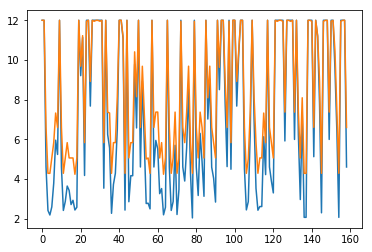

In [449]:
f = h5py.File(filename)
r_ = f['UntitledRewarduL']['Data'][0, :]
plt.plot(r_[r_>0])
plt.plot(dt_motor*12.0/dt_motor[0])

In [448]:
motor = f['UntitledMotor' + chamber_id[-1]]['Data'][0, :stop_idx]
thresh = 0.10 * np.max(motor)
is_pump = (motor > thresh).astype(np.int32)
idx_pump_start = (np.argwhere((is_pump - np.roll(is_pump, -1)) == -1) + 1).flatten()
idx_pump_end = (np.argwhere((is_pump - np.roll(is_pump, -1)) == 1) + 1).flatten()
t_motor = idx_pump_start / fs
dt_motor = (idx_pump_end - idx_pump_start) / fs

In [434]:
np.min(dt_motor)

0.11018897999999994

In [440]:
m = ((12.0 - 2.0)/(np.max(dt_motor) - np.min(dt_motor)))
r_motor = lambda dt: m*dt - m*np.max(dt_motor) + 12.0

### Batch analysis

In [103]:
base_dir = 'G:\\My Drive\\Projects\\foraging\\data\\simulation_data\\free_lick\\'
mouse_ids = ['j6z%d' % i for i in np.arange(1, 8)]
exp_names = mouse_ids
results_dir = base_dir + 'batch_01-15-19\\'
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

In [125]:
training_days = []
harvest_rate = []
dt_patch = []
dt_interpatch = []

for exp_name in exp_names:
    training_days.append(np.load(base_dir + exp_name + '\\training_days.npy'))
    harvest_rate.append(np.load(base_dir + exp_name + '\\harvest_rate.npy'))
    dt_patch.append(np.load(base_dir + exp_name + '\\residence_time.npy'))
    dt_interpatch.append(np.load(base_dir + exp_name + '\\travel_time.npy'))

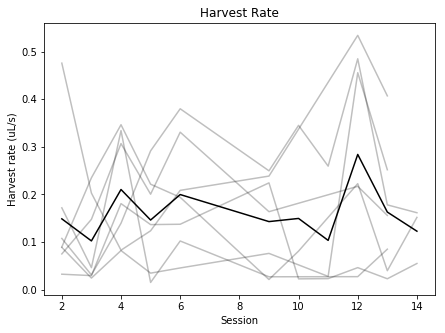

In [161]:
fig, ax = plt.subplots(figsize=(7, 5))

days = np.unique(flatten_list(training_days))

counts = np.zeros(len(days))
hr_mean = np.zeros(len(days))
for i, [ds, hr] in enumerate(zip(training_days, harvest_rate)):
    idx = np.searchsorted(days, ds)
    hr_mean[idx] += hr
    counts[idx] += 1
    
    ax.plot(ds, hr, color='black', alpha=0.25)
    
hr_mean /= counts

ax.plot(days, hr_mean, color='black', alpha=1.0)
ax.set_title('Harvest Rate')
ax.set_xlabel('Session')
ax.set_ylabel('Harvest rate (uL/s)')

plt.savefig(results_dir + 'harvest_rate_all.png')